Pokemon classifier
==================

Steps:
- 0. Data exploration
- 1. Detect human faces
- 2. Detect Pokémon

# Datasets

- [Pokemon Generation One](https://www.kaggle.com/lantian773030/pokemonclassificationone). 
  This dataset will be used to train and evaluate a Pokémon detector and a classifier of Pokémon species.
- [Labeled Faces in the Wild Home](http://vis-www.cs.umass.edu/lfw/lfw.tgz).
  This dataset will be used to evaluate a human face detector.
- [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz).
  This dataset will be used to train the Pokémon detector, providing examples not representing Pokémon.

# 0. Data exploration

In [1]:
import copy
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim, nn
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
from torchvision import models, transforms
from torch.utils.data import RandomSampler

In [2]:
import utils

In [3]:
# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
pokemon_files = np.array(glob("data/Pokemon/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total pokemon images.' % len(pokemon_files))

There are 13233 total human images.
There are 6837 total pokemon images.


## Human dataset exploration

In [4]:
df_human = utils.load_dataset('data/lfw')
df_human

,target,label,filename
0,5360,Tim_Curry,data/lfw/Tim_Curry/Tim_Curry_0001.jpg
1,3434,Mahmoud_Abbas,data/lfw/Mahmoud_Abbas/Mahmoud_Abbas_0023.jpg
2,3807,Michel_Charles_Chretien,data/lfw/Michel_Charles_Chretien/Michel_Charle...
3,26,Abid_Hamid_Mahmud_Al-Tikriti,data/lfw/Abid_Hamid_Mahmud_Al-Tikriti/Abid_Ham...
4,3957,Mona_Locke,data/lfw/Mona_Locke/Mona_Locke_0001.jpg
...,...,...,...
13228,5252,Tang_Jiaxuan,data/lfw/Tang_Jiaxuan/Tang_Jiaxuan_0010.jpg
13229,2122,Hestrie_Cloette,data/lfw/Hestrie_Cloette/Hestrie_Cloette_0001.jpg
13230,2175,Hugo_Chavez,data/lfw/Hugo_Chavez/Hugo_Chavez_0069.jpg
13231,373,Ariel_Sharon,data/lfw/Ariel_Sharon/Ariel_Sharon_0045.jpg


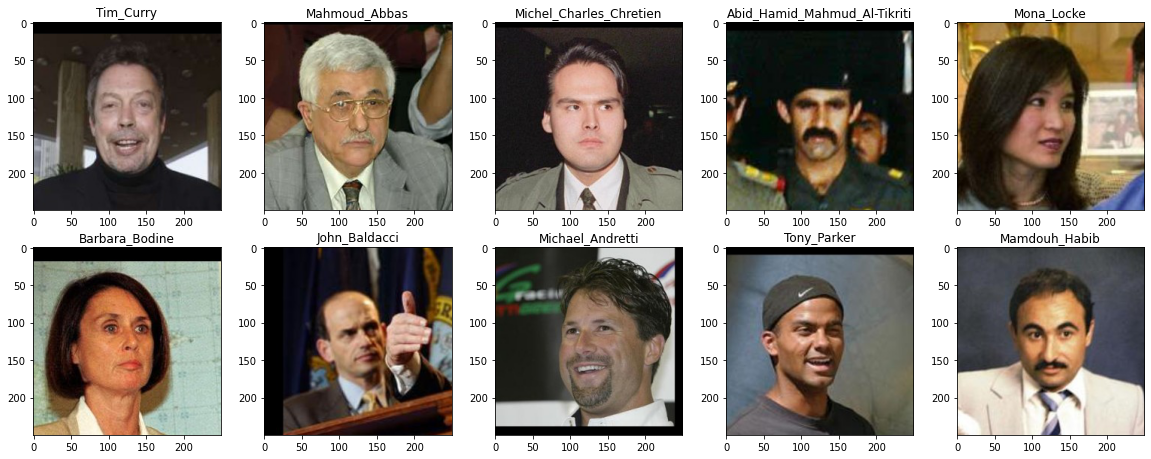

In [5]:
utils.show_first_img(df_human)

## Pokémon dataset exploration

In [6]:
df_pokemon = utils.load_dataset('data/Pokemon')
df_pokemon

,target,label,filename
0,74,Magikarp,data/Pokemon/Magikarp/59c928d4b8fc40f48d4c5759...
1,84,Moltres,data/Pokemon/Moltres/c026fa5056c84c02b8bd937d5...
2,11,Butterfree,data/Pokemon/Butterfree/59a63a02e61a4945a060e8...
3,145,Weepinbell,data/Pokemon/Weepinbell/39098299faa74451ae1b2e...
4,149,Zubat,data/Pokemon/Zubat/78bf5e565dad458dbc9926e1eec...
...,...,...,...
6832,86,Muk,data/Pokemon/Muk/46549609739e41c191ec1fba66a3f...
6833,117,Sandshrew,data/Pokemon/Sandshrew/50fc676b907246868bad74e...
6834,118,Sandslash,data/Pokemon/Sandslash/11d64851bc1e4c9da97b09e...
6835,121,Seaking,data/Pokemon/Seaking/55316aba966146e5aae002dc5...


Removes SVG files

In [7]:
df_pokemon = df_pokemon[df_pokemon.apply(lambda x: not x.filename.endswith('.svg'), axis=1)]
df_pokemon

,target,label,filename
0,74,Magikarp,data/Pokemon/Magikarp/59c928d4b8fc40f48d4c5759...
1,84,Moltres,data/Pokemon/Moltres/c026fa5056c84c02b8bd937d5...
2,11,Butterfree,data/Pokemon/Butterfree/59a63a02e61a4945a060e8...
3,145,Weepinbell,data/Pokemon/Weepinbell/39098299faa74451ae1b2e...
4,149,Zubat,data/Pokemon/Zubat/78bf5e565dad458dbc9926e1eec...
...,...,...,...
6832,86,Muk,data/Pokemon/Muk/46549609739e41c191ec1fba66a3f...
6833,117,Sandshrew,data/Pokemon/Sandshrew/50fc676b907246868bad74e...
6834,118,Sandslash,data/Pokemon/Sandslash/11d64851bc1e4c9da97b09e...
6835,121,Seaking,data/Pokemon/Seaking/55316aba966146e5aae002dc5...


#### Number of classes

In [8]:
print('Number of Pokémon species:', len(df_pokemon["label"].unique()))

Number of Pokémon species: 150


We miss 1 Pokémon in our dataset (Gen 1 is about 151 Pokémon), but we will ignore this issue

#### Show samples

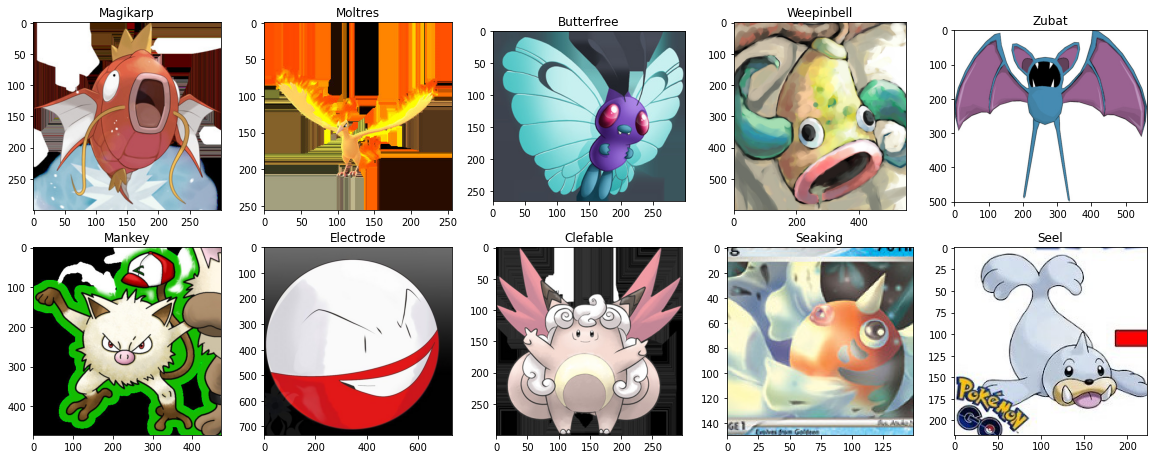

In [9]:
utils.show_first_img(df_pokemon)

## Repartition of images per class

std = 6.741387744732698


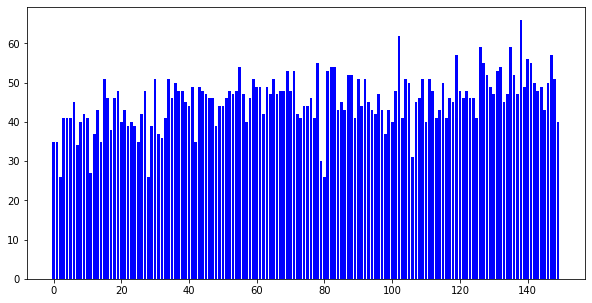

In [10]:
counts = df_pokemon.groupby('target').size().reset_index(name="Counts")
plt.figure(figsize=(10,5))
plt.bar(range(len(counts)), counts['Counts'], color = 'blue')
print('std =', df_pokemon.groupby('target').size().std())

Standard deviation is about 7.<br>
The repartition between classes is not perfect, but it will be ok.


# 1. Detect Humans

We use OpenCV `cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')` to detect human faces.<br>
See [utils.detect_human_face](utils.py) for implementation.

In [11]:
import cv2
from tqdm import tqdm

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
tqdm.pandas()

/home/bazema/workspace/venv_pytorch/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


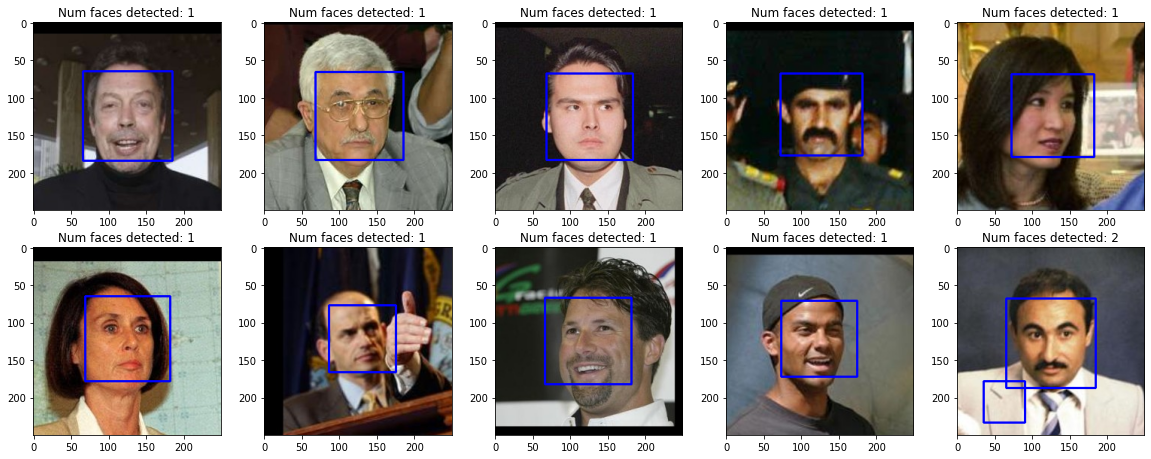

In [12]:
utils.detect_human_faces(df_human["filename"][:10].values)

In [13]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [14]:
df_human_sample = df_human[:100]
df_pokemon_sample = df_pokemon[:100]

df_human_sample.loc[df_human_sample.index.tolist(), 'face_detected'] = df_human_sample.progress_apply(lambda x: face_detector(x.filename), axis=1)
df_pokemon_sample.loc[df_pokemon_sample.index.tolist(), 'face_detected'] = df_pokemon_sample.progress_apply(lambda x: face_detector(x.filename), axis=1)

100%|██████████| 100/100 [00:02<00:00, 33.70it/s]
/home/bazema/workspace/venv_pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/bazema/workspace/venv_pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


In [15]:
print('Faces detected in Human sample:')
df_human_sample.groupby("face_detected").size().reset_index(name="Counts")

Faces detected in Human sample:


,face_detected,Counts
0,False,1
1,True,99


In [16]:
print('Faces detected in Pokemon sample:')
df_pokemon_sample.groupby("face_detected").size().reset_index(name="Counts")

Faces detected in Pokemon sample:


,face_detected,Counts
0,False,98
1,True,2


### Explore human faces not detected in human sample

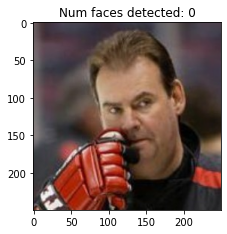

In [17]:
df_human_sample_no_faces = df_human_sample[df_human_sample["face_detected"] == False]
utils.detect_human_faces(df_human_sample_no_faces["filename"].values)

### Explore Pokémon images detected as human faces

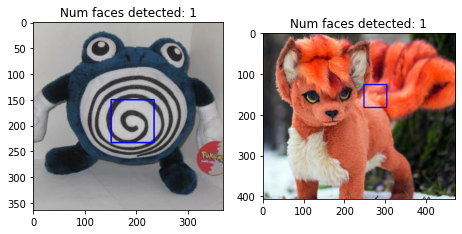

In [18]:
df_pokemon_sample_faces = df_pokemon_sample[df_pokemon_sample["face_detected"] == True]
utils.detect_human_faces(df_pokemon_sample_faces["filename"].values)

### Interpretation

We detected 99% of faces in the Human sample and only 2% in the Pokémon sample.<br>
Ideal result would be 100% for humans and 0% for pokémon, but this result is pretty good.

# 2. Detect Pokémon

In order to detect Pokémon among images, we need to train a model with images of Pokémon and images of other classes.<br>
We will use transfer learning in order to speed up the training process.

Our problem is a classification with 2 classes: "Pokemon", "Other".

In [19]:
resnet50 = models.resnet50(pretrained=True)

In [20]:
# Freeze pre-trained layers to do transfer learning
for param in resnet50.parameters():
    param.requires_grad = False
    

resnet50.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.003)

In [21]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transform = {'train': transforms.Compose([
  transforms.RandomResizedCrop(size=64),
  transforms.RandomRotation(degrees=15),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean_nums, std_nums)

]), 'val': transforms.Compose([
  transforms.Resize(size=64),
  #transforms.CenterCrop(size=224),
  transforms.ToTensor(),
  transforms.Normalize(mean_nums, std_nums)

]), 'test': transforms.Compose([
  transforms.Resize(size=64),
  #transforms.CenterCrop(size=224),
  transforms.ToTensor(),
  transforms.Normalize(mean_nums, std_nums)
]),
}

## Build dataset

In [22]:
pokemon_detector_classes = ('Pokemon' , 'Other')

In [23]:
pokemon_dataset = torchvision.datasets.ImageFolder('data/Pokemon', transform=transform['train'])

# Set class for each Pokemon to 0
pokemon_dataset.target_transform = lambda x: pokemon_detector_classes.index('Pokemon')

In [24]:
# Check class = 0 for every images : take random index
[(f'index={i}', f'class={pokemon_dataset[i][1]}') for i in np.random.randint(len(pokemon_dataset), size=5)]

[('index=2681', 'class=0'),
 ('index=3865', 'class=0'),
 ('index=3675', 'class=0'),
 ('index=2698', 'class=0'),
 ('index=4378', 'class=0')]

In [25]:
pokemon_test_size = round((len(pokemon_dataset))*.15)
pokemon_train_size = len(pokemon_dataset) - pokemon_test_size

lengths=[round(len(pokemon_dataset) * 3/4), round(len(pokemon_dataset)* 1/4)]
pokemon_dataset_train, pokemon_dataset_test = torch.utils.data.random_split(pokemon_dataset, [pokemon_train_size, pokemon_test_size])
print('train size = %s ; test_size = %s ' % (len(pokemon_dataset_train), len(pokemon_dataset_test)))

train size = 5797 ; test_size = 1023 


In [26]:
cifar100_train = torchvision.datasets.CIFAR100(root='data/', train=True, download=True, transform=transform['train'])
cifar100_test = torchvision.datasets.CIFAR100(root='data/', train=False, download=True, transform=transform['test'])

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Set class for each image to 1
cifar100_train.target_transform = lambda x: pokemon_detector_classes.index('Other')
cifar100_test.target_transform = lambda x: pokemon_detector_classes.index('Other')

In [28]:
print('train size = %s ; test_size = %s ' % (len(cifar100_train), len(cifar100_test)))

RandomSampler(cifar100_train, replacement=True, num_samples=5000)
RandomSampler(cifar100_train, replacement=True, num_samples=1000)

print('train size = %s ; test_size = %s ' % (len(cifar100_train), len(cifar100_test)))

train size = 50000 ; test_size = 10000 
train size = 50000 ; test_size = 10000 


In [29]:
# Check class = 1 for every images : take random index
[(f'index={i}', f'class={cifar100_train[i][1]}') for i in np.random.randint(len(cifar100_train), size=5)]

[('index=32394', 'class=1'),
 ('index=15554', 'class=1'),
 ('index=10294', 'class=1'),
 ('index=38104', 'class=1'),
 ('index=32265', 'class=1')]

In [30]:
RandomSampler(cifar100_train, replacement=True, num_samples=5000)
RandomSampler(cifar100_train, replacement=True, num_samples=1000)

In [31]:
pokemon_detector_train = torch.utils.data.ConcatDataset([pokemon_dataset_train, cifar100_train])
pokemon_detector_test = torch.utils.data.ConcatDataset([pokemon_dataset_test, cifar100_test])

In [32]:
batch_size = 16

pokemon_detector_loader_train = torch.utils.data.DataLoader(pokemon_detector_train,
                                     batch_size, shuffle=True, drop_last=True)
pokemon_detector_loader_test = torch.utils.data.DataLoader(pokemon_detector_test,
                                     batch_size, shuffle=True)

In [33]:
len(pokemon_detector_loader_train)

3487

In [34]:
for i in range(2):
    batch_x, batch_y = next(iter(pokemon_detector_loader_train))
    print(np.shape(batch_x), batch_y)

torch.Size([16, 3, 64, 64]) tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])
torch.Size([16, 3, 64, 64]) tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


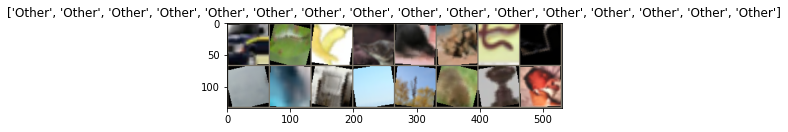

In [35]:
# Get a batch of training data
inputs, classes = next(iter(pokemon_detector_loader_train))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

utils.imshow_tensor(out, std_nums, mean_nums, title=[pokemon_detector_classes[x] for x in classes])

## Define data loaders

In [36]:
data_loaders = {
    'train': pokemon_detector_loader_train,
    'val': pokemon_detector_loader_test
}
dataset_sizes = {
    'train': len(pokemon_detector_loader_train),
    'val': len(pokemon_detector_loader_test)
}

## Prototype model Transfer learning

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [38]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, ground truth: {}'
                             .format(pokemon_detector_classes[preds[j]],
                                     pokemon_detector_classes[labels[j]]))
                utils.imshow_tensor(inputs.cpu().data[j], std_nums, mean_nums)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Fine-tuning the convnet

In [39]:
'''
NOT RELEVANT HERE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, len(pokemon_detector_classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)
'''

'\nNOT RELEVANT HERE\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\nmodel_ft = models.resnet50(pretrained=True)\nnum_ftrs = model_ft.fc.in_features\n# Here the size of each output sample is set to 2.\nmodel_ft.fc = nn.Linear(num_ftrs, len(pokemon_detector_classes))\n\nmodel_ft = model_ft.to(device)\n\ncriterion = nn.CrossEntropyLoss()\n\n# Observe that all parameters are being optimized\noptimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)\n\n# Decay LR by a factor of 0.1 every 7 epochs\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)\n\n\nmodel_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,\n                       num_epochs=1)\n'

### ConvNet as fixed feature extractor

We freeze the network and one layer with 2 outputs for our 2 classes.

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [43]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 1.1557 Acc: 15.5942
val Loss: 1.7753 Acc: 15.3512

Training complete in 25m 41s
Best val Acc: 15.351234


In [44]:
PATH = './pokemon_detector.pth'
torch.save(model_conv, PATH)

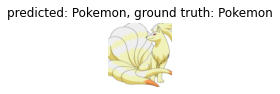

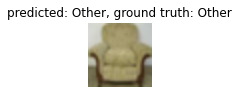

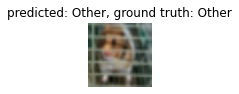

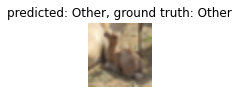

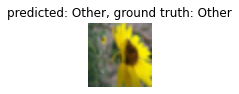

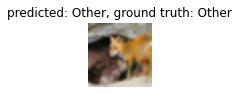

In [45]:
visualize_model(model_conv, num_images=6)

plt.ioff()
plt.show()

In [46]:
correct = 0
total = 0
with torch.no_grad():
    for data in pokemon_detector_loader_test:
        images, labels = data
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


In [47]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in pokemon_detector_loader_test:
        images, labels = data
        outputs = model_conv(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(2):
    if class_total[i] == 0.0:
        print(pokemon_detector_classes[i])
    else:
        print('Accuracy of %5s : %2d %%' % (
            pokemon_detector_classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Pokemon : 91 %
Accuracy of Other : 95 %


### Interpretation

Our model is not yet accurate, it is fine because we trained it only during 1 epoch

## Train with SageMaker
Now that our model runs without errors, we will train it on AWS GPU using SageMaker

We will use `sources_detector` directory as `source_dir` where can find the [train.py](source_detector/train.py)

Training script workflow:
- Loads training data:
    - Pokemon data from local dir
    - CIFAR100 is downloaded with `torchvision.datasets.CIFAR100(root=data_dir, download=True, ...)`
- Build the training and validation datasets concatenating Pokemon and CIFAR100 datasets
- Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
- Instantiates ResNet50 model pretrained: `models.resnet50(pretrained=True)`
- Configure output layer with 2 neurons
- Trains that model and at each epoch saves the better model
- Finally, saves the best model so that it can be hosted/deployed, later

In [9]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker.local import LocalSession

### Local Mode with 1 epoch


In [13]:
sagemaker_session = LocalSession(boto3.session.Session(region_name='us-east-1'))
sagemaker_session.config = {'local': {'local_code': True}}
# session and role
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [14]:
output_path = f'file://output'

estimator = PyTorch(entry_point='train.py',
                   source_dir='/home/ec2-user/SageMaker/pokemon_classifier/source_detector',
                    framework_version='1.6',
                    py_version='py3',
                   role=role,
                   instance_count=1,
                   instance_type='local',
                   output_path=output_path,
                    sagemaker_session=sagemaker_session,
                   hyperparameters={
                        'epochs': 1, # could change to higher
                       'batch-size': 4
                    })

In [ ]:
estimator.fit({'train': 'file://data'})

### Train on GPU with 60 epochs

In [ ]:
sagemaker_session = sagemaker.Session()

In [ ]:
# should be the name of directory you created to save your features data
data_dir = 'data'

# set prefix, a descriptive name for a directory  
prefix = 'train_data_pokemon_detector'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

In [ ]:
output_path = f's3://{bucket}/pokemon_detector/output'

estimator = PyTorch(entry_point='train.py',
                   source_dir='source_detector',
                    framework_version='1.6',
                    py_version='py3',
                   role=role,
                   instance_count=1,
                   instance_type='ml.p2.xlarge',
                   output_path=output_path,
                    sagemaker_session=sagemaker_session,
                   hyperparameters={
                        'epochs': 80 # could change to higher
                    })

In [ ]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': input_data})